# Python Group Assignment Part 1: ML Model for Predicting Attendance 

### Kaumu Joshi, Xavi Hernan, Jeremy Ifrah, Jules Salino, Firanol Abdisa

## **Overview**
1. [Data Collection](#0)
2. [Exploratory Data Analysis](#1) 
3. [Data Preprocessing](#2)   
    3.1. [Remove Outliers](#3)   
    3.2. [Remove Redundant](#4)   
    3.3. [Replace Null Values](#5)   
4. [Feature Engineering](#6)   
    4.1. [Feature Creation](#7)   
    4.2. [Encoding](#8)   
    4.3. [Feature Importance](#9)   
5. [Modelling](#10)  
    5.1. [Train Test Split](#11)  
    5.2. [Scaling](#12)  
    5.2. [Selection](#13)  
6. [Prediction](#14)  

<a id='0'></a>
## 1. Data Collection

In [1]:
# Import all required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.express as px
import my_lib # This is our library with all functions we created
pd.options.display.max_columns = None
py.init_notebook_mode(connected=True) # this allows to display plotly graphs in Jupyter

C:\Users\Kaumu Joshi\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kaumu Joshi\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Kaumu Joshi\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Import the data sets
construction_df = pd.read_csv("./construction_dataset.csv")
production_df = pd.read_csv("./production_dataset.csv")

<a id='1'></a>
## 2. Exploratory Data Analysis

In [3]:
construction_df.head()

,Unnamed: 0,year,home_team,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead,hum>average,attend_inc,attend_thousands
0,0,2012,Baltimore Orioles,APR,6,32741,Friday,Minnesota Twins,59,Clear,Day,NO,NO,NO,NO,NO,NaN,33
1,1,2012,Baltimore Orioles,APR,7,22072,Saturday,Minnesota Twins,63,Clear,Night,NO,NO,NO,NO,YES,-10669.0,22
2,2,2012,Baltimore Orioles,APR,8,10317,Sunday,Minnesota Twins,68,Clear,Day,NO,NO,NO,NO,YES,-11755.0,10
3,3,2012,Baltimore Orioles,APR,9,17835,Monday,New York Yankees,65,Cloudy,Night,NO,NO,NO,NO,NO,7518.0,18
4,4,2012,Baltimore Orioles,APR,10,17261,Tuesday,New York Yankees,62,Clear,Night,NO,NO,NO,NO,NO,-574.0,17


In [4]:
construction_df.dtypes

Unnamed: 0            int64
year                  int64
home_team            object
month                object
day                   int64
attend                int64
day_of_week          object
opponent             object
temp                  int64
skies                object
day_night            object
cap                  object
shirt                object
fireworks            object
bobblehead           object
hum>average          object
attend_inc          float64
attend_thousands      int64
dtype: object

In [5]:
print(construction_df[["year","month"]].value_counts())

year  month
2012  AUG      424
      MAY      424
      JUN      404
      JUL      383
      APR      334
      SEP      212
dtype: int64


Observation: 
- The year is a constant across all datasets and can be disregarded.
- June - August months are not represented in the test set, only September is present in both datasets. 

### 2.1. Distributions & Correlations

In [6]:
fig = px.histogram(construction_df, x="attend", marginal = "box")
fig.update_layout(title = "Distribution of Attendance (Target Variable)",width=800,height= 600)
fig.show()

In [7]:
fig = px.histogram(construction_df, x="temp", marginal = "box")
fig.update_layout(title = "Distribution of Temperature", width=800,height= 600)
fig.show()

To smooth our dataset, we will remove the outlier having low temperature, as it represents only one row.

#### Relationship of Home team with attendance

In [8]:
construction_df = construction_df.sort_values('attend')
# Plot Neighborhoods against their distribution of housing price using box plot
fig = px.box(construction_df,y="attend",  x="home_team"
            , color_discrete_sequence=["orange"], orientation = 'v')

fig.update_layout(title = "Distribution of attendance by home_teams")
fig.show()

Observation: The feature "home_team" is highly correlated with the attendance, we can include its impact during feature engineering

#### Relationship of Opponent team with attendance

In [9]:
construction_df = construction_df.sort_values('attend')
# Plot Neighborhoods against their distribution of housing price using box plot
fig = px.box(construction_df,y="attend",  x="opponent"
            , color_discrete_sequence=["orange"], orientation = 'v')

fig.update_layout(title = "Distribution of attendance by opponent")
fig.show()

Observation: The feature "opponent" is not as correlated with the attendance, but we choose to include its impact during feature engineering to see if the model can be improved.

#### Relationship of day_of_week with attendance

In [10]:
construction_df = construction_df.sort_values('attend')
# Plot Neighborhoods against their distribution of housing price using box plot
fig = px.box(construction_df,y="attend",  x="day_of_week"
            , color_discrete_sequence=["orange"], orientation = 'v')

fig.update_layout(title = "Distribution of attendance by day_of_week")
fig.show()

Observation: We can see that for the weekend days (Friday, Saturday, Sunday) the attendance is slightly higher than for the weekdays. We will include this impact in our model by adding a weekend column.

### 2.1. Null Values 

In [11]:
# show the % of missing value rows for each column
null_counts = round(100*construction_df.isnull().mean(),2)

# filter out the rows without any missing values and sort in descending order, convert to dataframe
null_counts = pd.DataFrame(data = null_counts[null_counts>0].sort_values(ascending = False), columns = ['%'])

# Create column to show the sum of the rows having missing values for each column
null_counts['# Rows'] = construction_df.isnull().sum()
# Create column to show the datatype of each column
null_counts['DataType'] = construction_df.dtypes

null_counts

,%,# Rows,DataType
hum>average,4.95,108,object
attend_inc,1.38,30,float64


<a id='2'></a>
## 3. Data Preprocessing

<a id='3'></a>
### 3.1. Remove Outliers: 
To smooth our dataset, we will remove the outlier having low temperatures that are below 37 degrees, as it represents only one row.

In [12]:
construction_df = construction_df[construction_df["temp"]> 37]
production_df = production_df[production_df["temp"]> 37]

<a id='4'></a>
### 3.2. Remove Redundant columns:
- "year": We have seen that year is a constant column showing 2012.
- "Attend_inc" & "attend_thousands": These columns show the same information as "attend" and are not required further.
- "Unnamed: 0": This is an index column and unique for each row.

In [13]:
#Define columns to delete
delete_columns = ["year","attend_inc","attend_thousands","Unnamed: 0"]
# Drop from both construction & production dataset
construction_df = construction_df.drop(delete_columns, axis = 1)
production_df_updated = production_df.drop(delete_columns, axis = 1)

<a id='5'></a>
### 3.3. Replace Null Values: 
"hum>average": This column is a YES/NO categorical column, indicating whether the humidity is above average or not. 
For null values, we assume that the humidity is not above average and replace it with "NO".

In [14]:
construction_df["hum>average"] = construction_df["hum>average"].fillna("NO")
production_df_updated["hum>average"] = production_df_updated["hum>average"].fillna("NO")

<a id='6'></a>
## 4. Feature Engineering

<a id='7'></a>
### 4.1. Feature Creation

#### 4.1.1. September: 
Since only this month is present in both training & test set, we created a flag for this month to include its' importance in the model. We will then drop the month column.
We have defined a function called september() available in our library my_lib, to compute this feature.


In [15]:
#Apply lambda function to calculate feature using september() function on month column.
construction_df["Is_Sep"] = construction_df["month"].apply(lambda x: my_lib.september(x))
construction_df = construction_df.drop("month", axis = 1)

# Repeat process for production dataset
production_df_updated["Is_Sep"] = production_df_updated["month"].apply(lambda x: my_lib.september(x))
production_df_updated = production_df_updated.drop("month", axis = 1)

#### 4.1.2. Team scores: 
We want to include the impact of the popularity of different teams in our model, since we have seen a strong correlation of home team with the attendance. 
We thought of including external information for this purpose, but to not overcomplicate the problem, we decided to build our own scoring using the following methodology:
- First we calculate the average attendance of each home team, this represents our "home_team_score"
- We then merge the this dataframe to our original one, to include this score as a new column
- We repeat this process also to score the opponent team and create the column "opponent_team_score"
- Let's store the score dataframes to csv, to call it in the model of the production dataset

In [16]:
columns = ['home_team','opponent']

# Calculate mean attendance and call it score
for score_col in columns:
    mean_df = construction_df[[score_col, 'attend']].groupby(score_col).mean()
    mean_df = mean_df.rename(columns={"attend": "score" })

    # Load to csv for using this dataframe in production dataset
    mean_df.to_csv(score_col + '_scores.csv',index=True)
    
    #Merge dataframe including mean score with construction 
    construction_df = pd.merge(construction_df, 
                         mean_df, 
                         on =score_col, 
                         how ='left')
    #Rename column to differentiate home score & opponent score
    construction_df = construction_df.rename(columns={"score": score_col + "_score" })

In [17]:
# Import the mean dataframe computed earlier
home_team_scores = pd.read_csv("./home_team_scores.csv")
opponent_scores = pd.read_csv("./opponent_scores.csv")

In [18]:
# Merge the dataframe including home teams and their average score with production dataset
production_df_updated = pd.merge(production_df_updated, 
                     home_team_scores, 
                     on = 'home_team', 
                     how ='left')

#Rename column to home_team_score
production_df_updated = production_df_updated.rename(columns={"score": 'home_team_score'})

# Merge the dataframe including opponent teams and their average score  with production dataset                                                              
production_df_updated = pd.merge(production_df_updated, 
                     opponent_scores, 
                     on = 'opponent', 
                     how ='left')
#Rename column to opponent_score
production_df_updated = production_df_updated.rename(columns={"score": 'opponent_score' })                                                              

#### 4.1.3. Weekend: 
We will include a column to flag if the day is Friday, Saturday or Sunday. These days have shown higher attendance in our dataset than the weekdays.
We have defined a function called weekend() available in our library my_lib, to compute this feature.

In [19]:
#Apply lambda function to calculate feature using weekend() function on day_of_week column.
construction_df['weekend'] = construction_df['day_of_week'].apply(lambda x: my_lib.weekend(x))
production_df_updated['weekend'] = production_df_updated['day_of_week'].apply(lambda x: my_lib.weekend(x))

#### 4.1.4. Weather: 
We will include a column to aggregate the temperature into three categories: 
- Cold: Temperature is below 60 degrees
- Moderate: Temperature is between 60 and 90 degrees
- Hot: Temperature is above 90 degrees

We have defined a function called weather() available in our library my_lib, to compute this feature.

In [20]:
#Apply lambda function to calculate feature using weather() function on temp column.
construction_df["weather"] = construction_df["temp"].apply(lambda x: my_lib.weather(x))
production_df_updated["weather"] = production_df_updated["temp"].apply(lambda x: my_lib.weather(x))

<a id='8'></a>
### 4.2. Encoding

- Binary Categorical Columns: We will replace YES/NO with 0/1. 
- Other Categorical Columns: We will apply One-Hot Encoding.

In [21]:
# Define Categorical columns with YES/NO:
zero_columns = ["cap","shirt","fireworks","bobblehead","hum>average"] 

# replace with 0 or 1
for column in zero_columns:
    construction_df[column] = construction_df[column].replace({'YES': 1 , 'NO': 0})

# Define categorical columns having higher cardinality
dummy_df = construction_df[["opponent","home_team","day_night","day_of_week","skies","weather"]]

# Perform Dummy Encoding
dummy_df_encoded = pd.get_dummies(dummy_df)

# Drop the previous categorical columns from construction_df 
construction_df = construction_df.drop(columns = dummy_df)

# Merge the new dummy dataframe to construction_df
construction_df = pd.merge(
    left=construction_df,
    right=dummy_df_encoded,
    left_index=True,
    right_index=True,
    )

In [22]:
# replace categorical columns having YES/NO with 0 or 1
for column in zero_columns:
    production_df_updated[column] = production_df_updated[column].replace({'YES': 1 , 'NO': 0})

# Define categorical columns having higher cardinality
dummy_df = production_df_updated[["opponent","home_team","day_night","day_of_week","skies","weather"]]

# Perform Dummy Encoding
dummy_df_encoded = pd.get_dummies(dummy_df)

# Drop the previous categorical columns from construction_df 
production_df_updated = production_df_updated.drop(columns = dummy_df)

# Merge the new dummy dataframe to construction_df
production_df_updated = pd.merge(
    left=production_df_updated,
    right=dummy_df_encoded,
    left_index=True,
    right_index=True,
    )

<a id='9'></a>
### 4.3. Feature Importance

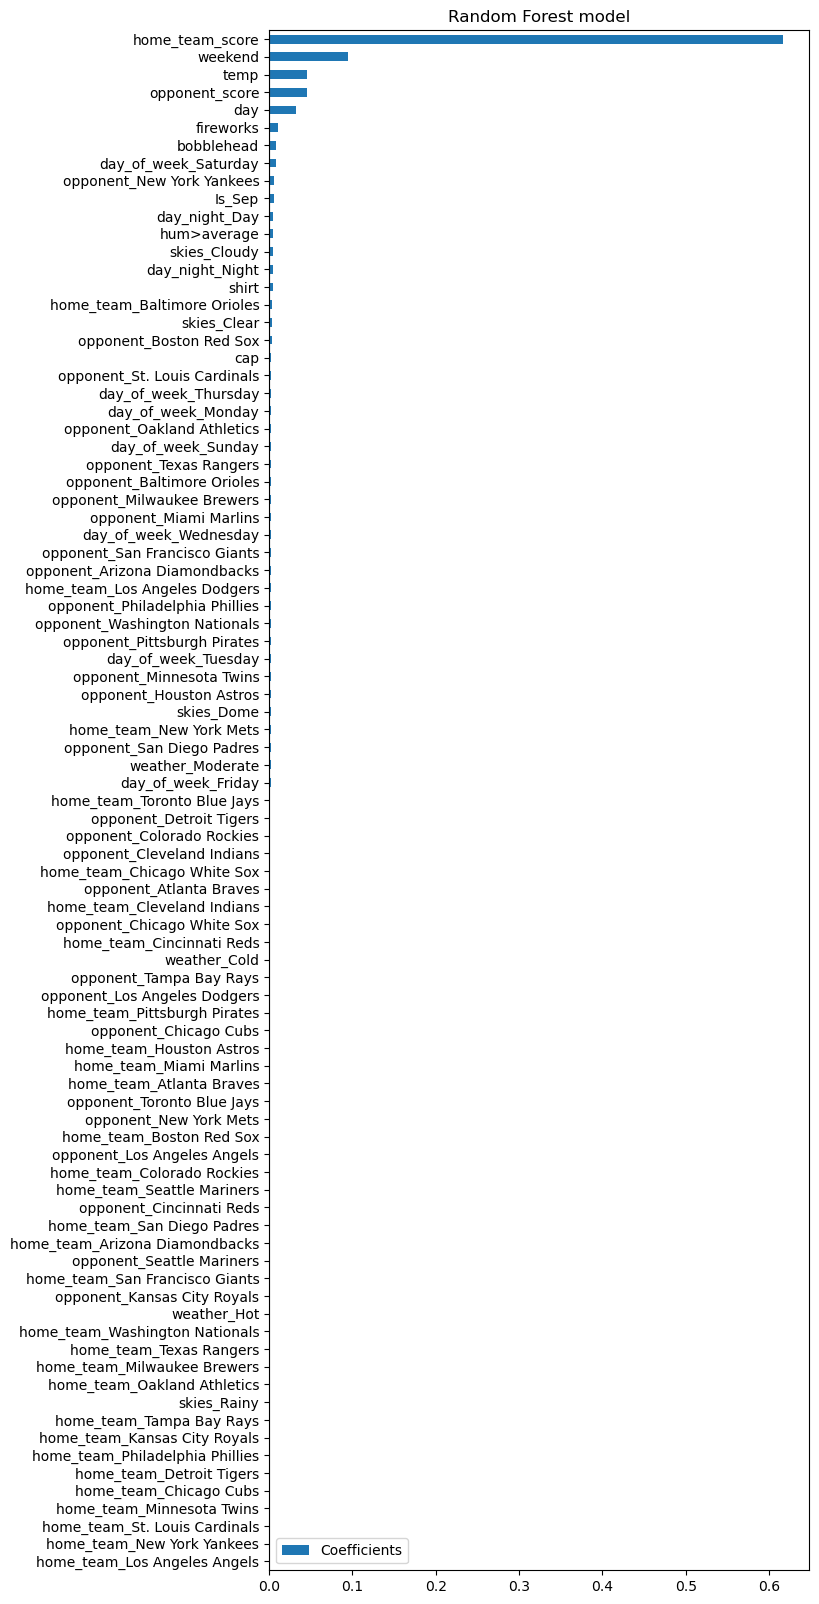

In [23]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Define X as our features of the dataset and y as the target variable attendance (attend) 
X = construction_df.drop(["attend"], axis=1) 
y = construction_df["attend"]

# Choose the model we are finally going to use
rnf_model = RandomForestRegressor(n_estimators = 100)
# Fit X and y
rnf_model.fit(X,y)

#to compute feature importance using this model
importance = rnf_model.feature_importances_

# Create dataframe with feature importance
coefs = pd.DataFrame(
   importance,
   columns=['Coefficients'], index=X.columns
)

# Plot features and their importance
coefs.sort_values('Coefficients').plot(kind='barh', figsize=(9, 20))
plt.title('Random Forest model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Our new features are amongst the most important for the target variable attendance, using Random Forest (Our final chosen model).

<a id='10'></a>
## 5. Modelling 

<a id='11'></a>
### 5.1. Train Test Split 

In [24]:
# importing feature scaling function
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Define X as our features of the dataset and y as the target variable attendance (attend) 
X = construction_df.drop(["attend"], axis=1)
y = construction_df["attend"]

# Define X_prod as our production features, remove our target variable attendance (attend) 
X_prod = production_df_updated.drop(["attend"], axis=1)

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=53)

<a id='12'></a>
### 5.2. Scaling

In [25]:
# Define scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

# apply feature scaling to all features
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_prod = scaler.transform(X_prod)

<a id='13'></a>
### 5.3. Selection

In [26]:
# Baseline Model Score using Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBModel

# Define model and fit with X_train and y_train
reg_model = LinearRegression()
reg_model.fit(X_train,y_train)

mape_train = mean_absolute_percentage_error(y_train,reg_model.predict(X_train))
mape_test = mean_absolute_percentage_error(y_test,reg_model.predict(X_test))

print("Train MAPE = {:.4} %".format(round(mape_train*100,4)) )
print("Test MAPE = {:.4} %".format(round(mape_test*100,4)) )

Train MAPE = 14.32 %
Test MAPE = 14.94 %


In [27]:
# XGBoost Model

# Define model and fit with X_train and y_train
xgb_model = XGBModel()
# Define parameters to test
param_grid = {'n_estimators':[50,100,200], 'max_depth':[None,5,10,15]}

# Perform gridsearch and save model with best parameters as grid_result
grid_search = GridSearchCV(xgb_model, param_grid, scoring="neg_mean_absolute_percentage_error")
grid_result = grid_search.fit(X_train, y_train)

# Print parameters of best performing model
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Compute MAPE for train and test set
mape_train = mean_absolute_percentage_error(y_train,grid_result.predict(X_train))
mape_test = mean_absolute_percentage_error(y_test,grid_result.predict(X_test))

# Print score
print("Train MAPE = {:.4} %".format(round(mape_train*100,4)) )
print("Test MAPE = {:.4} %".format(round(mape_test*100,4)) )


Best: -0.131413 using {'max_depth': 5, 'n_estimators': 50}
Train MAPE = 7.229 %
Test MAPE = 12.57 %


In [28]:
# Random Forest Model

# Define model and fit with X_train and y_train
rnf_model = RandomForestRegressor()
# Define parameters to test
param_grid = {'n_estimators':[150,200], 'max_depth':[None,30,45,60]}
grid_search = GridSearchCV(rnf_model, param_grid, scoring="neg_mean_absolute_percentage_error")
grid_result = grid_search.fit(X_train, y_train)

# Perform gridsearch and save model with best parameters as grid_result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


# Compute MAPE for train and test set
mape_train = mean_absolute_percentage_error(y_train,grid_result.predict(X_train))
mape_test = mean_absolute_percentage_error(y_test,grid_result.predict(X_test))

# Print score
print("Train MAPE = {:.4} %".format(round(mape_train*100,4)) )
print("Test MAPE = {:.4} %".format(round(mape_test*100,4)) )


Best: -0.132050 using {'max_depth': 60, 'n_estimators': 200}
Train MAPE = 4.822 %
Test MAPE = 12.55 %


The score using RandomForest Regressor is the same as using XGBoost, as we know RandomForest is better suited for overfitting & reducing variance, we select this as the final model.

<a id='14'></a>
## 6. Prediction

In [29]:
# Predict the targets of our production dataset
prod_pred = grid_result.predict(X_prod)

In [30]:
# Create dataframe with ID and the predicted attendance using our production dataset
result = production_df[['Unnamed: 0']]
result['attend'] = prod_pred

# Store to csv
result.to_csv('submission.csv',index=False)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_9388\1301694619.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

